**Import libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import glob
import tensorflow as tf
import tensorflow.keras.layers as tfl
import kagglehub
# Download latest version
path = kagglehub.dataset_download("kumaresanmanickavelu/lyft-udacity-challenge")

print("Path to dataset files:", path)
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

100%|██████████| 5.11G/5.11G [00:52<00:00, 105MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kumaresanmanickavelu/lyft-udacity-challenge/versions/1


# **Display images and ground truth masks**
The data has 5 sets of 1000 images and corresponding labels.

In [ ]:
def plot_images_and_masks(data_folder):
    subfolders = ['dataA', 'dataB', 'dataC', 'dataD', 'dataE']
    num_images_to_plot = 3

    for subfolder in subfolders:
        image_subfolder_path = os.path.join(data_folder, subfolder, subfolder, 'CameraRGB')
        mask_subfolder_path = os.path.join(data_folder, subfolder, subfolder, 'CameraSeg')

        image_files = os.listdir(image_subfolder_path)
        mask_files = os.listdir(mask_subfolder_path)

        for i in range(num_images_to_plot):
            image_path = os.path.join(image_subfolder_path, image_files[i])
            mask_path = os.path.join(mask_subfolder_path, mask_files[i])

            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.title(f'Image {i+1} - Subfolder: {subfolder}')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(mask)  # Display mask in grayscale
            plt.title(f'Mask {i+1} - Subfolder: {subfolder}')
            plt.axis('off')

            plt.show()


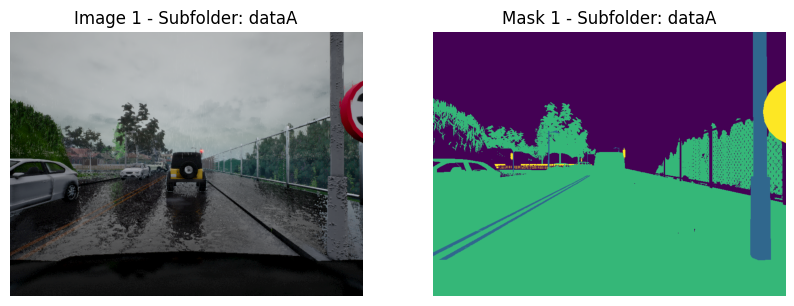

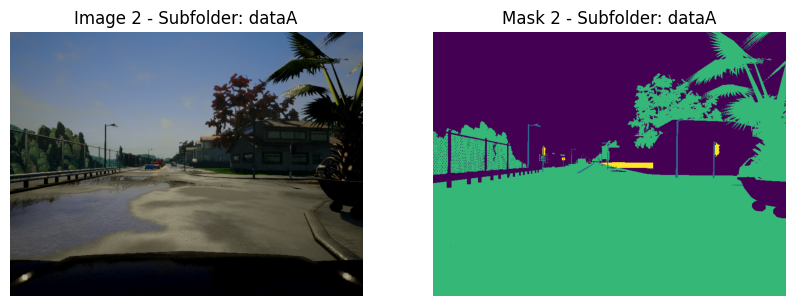

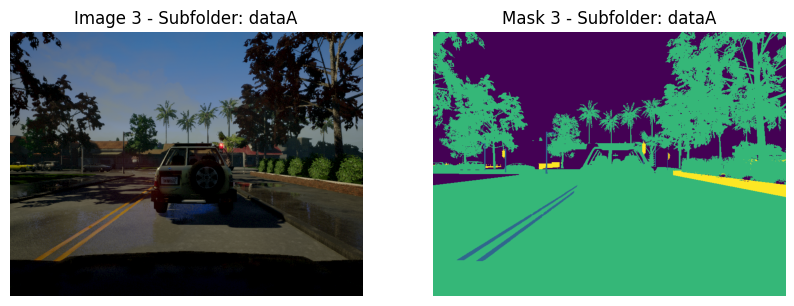

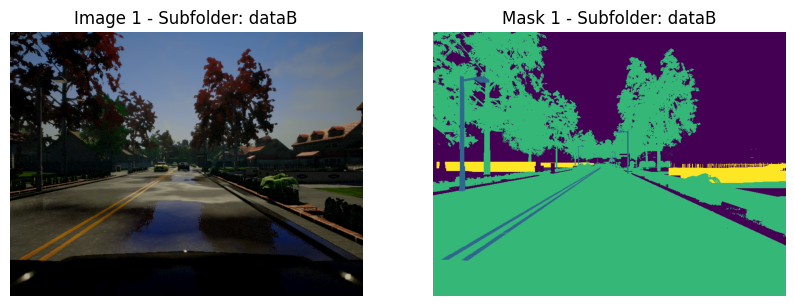

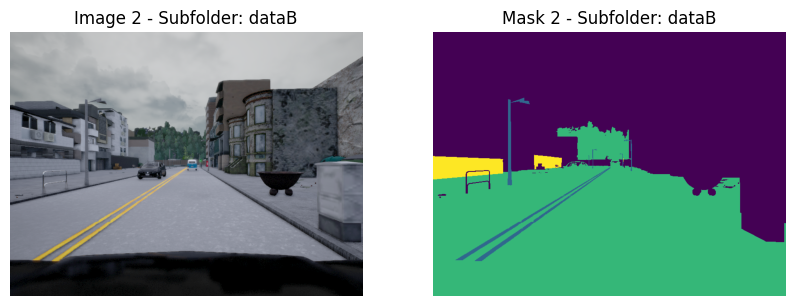

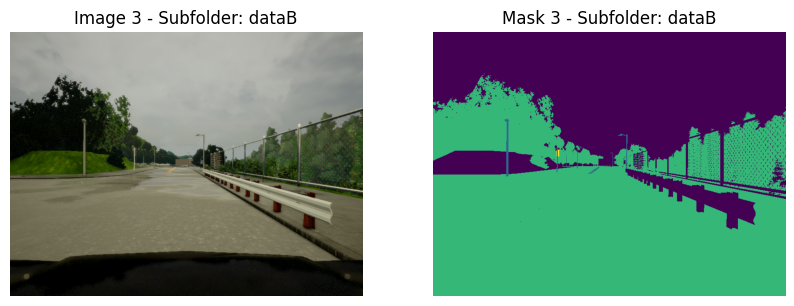

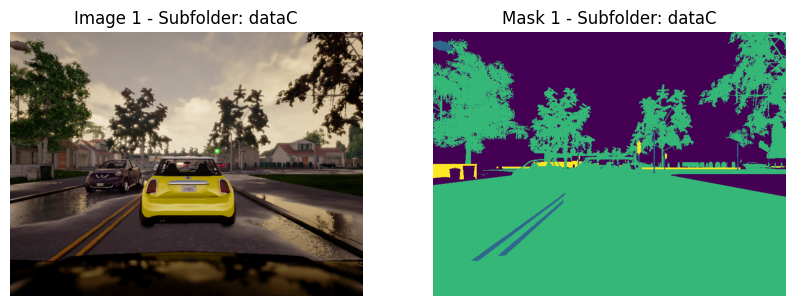

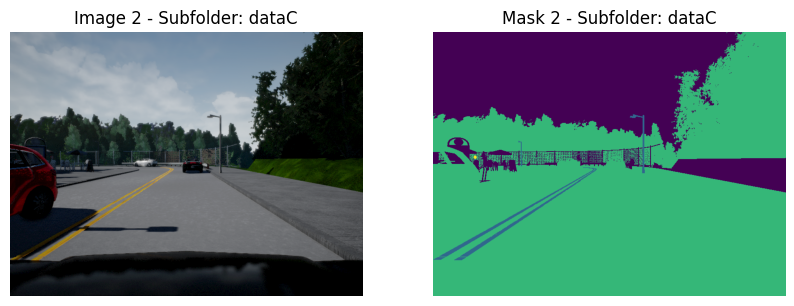

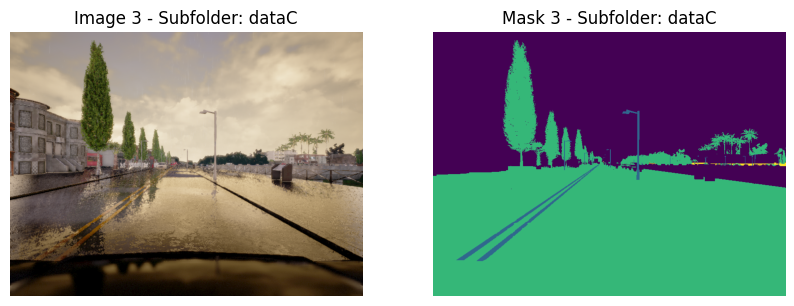

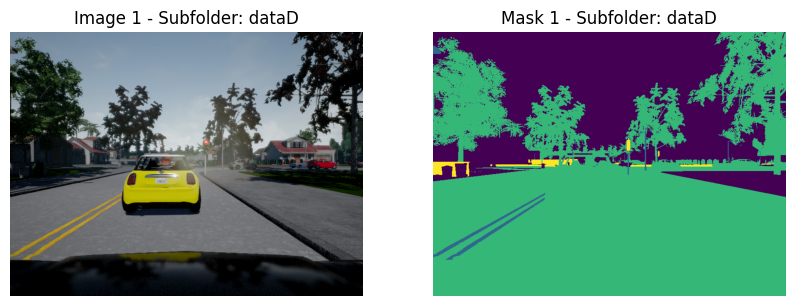

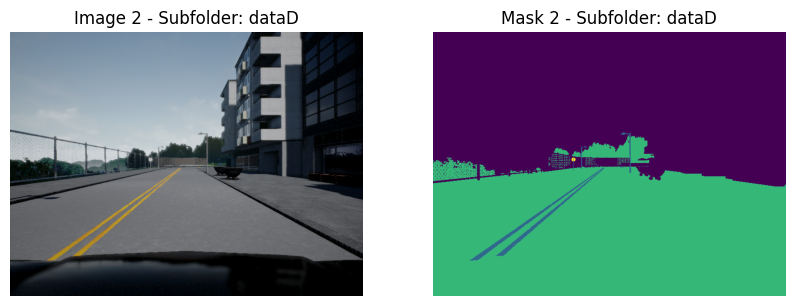

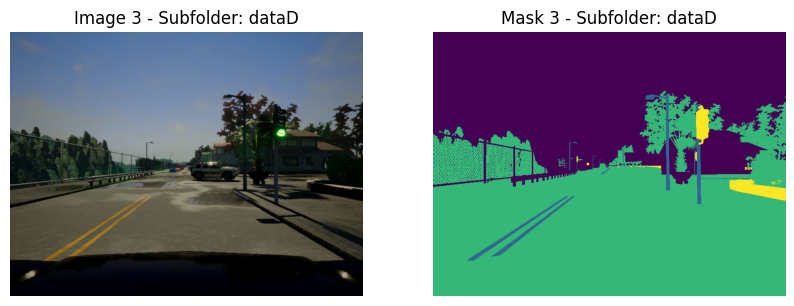

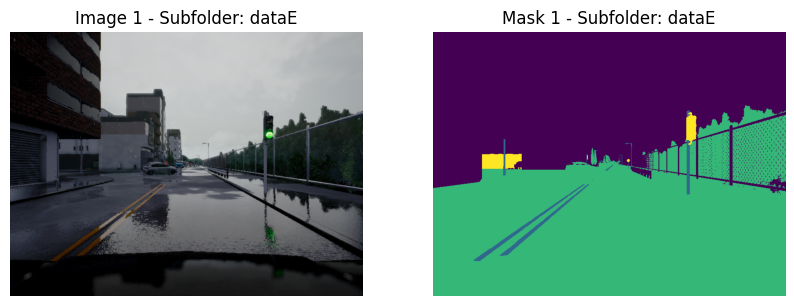

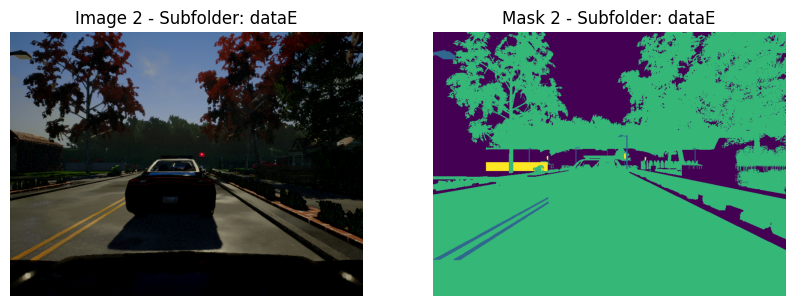

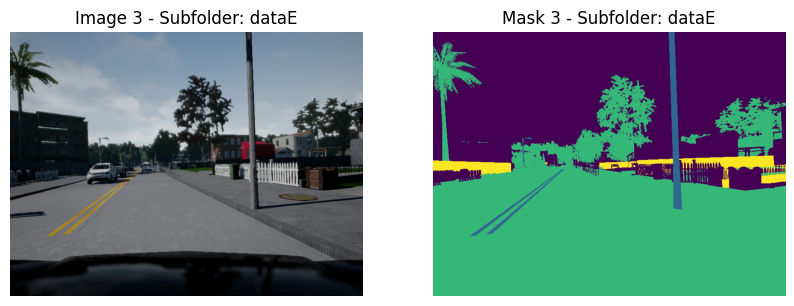

In [ ]:
data_folder = "/root/.cache/kagglehub/datasets/kumaresanmanickavelu/lyft-udacity-challenge/versions/1"
plot_images_and_masks(data_folder)

# storing images and masks in list

In [ ]:
import os
import glob

images_list = []
masks_list = []

# base dataset folder
data_folder = "/root/.cache/kagglehub/datasets/kumaresanmanickavelu/lyft-udacity-challenge/versions/1"

images_list = glob.glob(os.path.join(data_folder, "**/CameraRGB/*.png"), recursive=True)  # List of image file paths
masks_list = glob.glob(os.path.join(data_folder, "**/CameraSeg/*.png"), recursive=True)  # List of mask file paths

# Checking
print("Total images:", len(images_list))
print("Total masks:", len(masks_list))

Total images: 10000
Total masks: 10000


# Transforming the lists  to tensors

In [ ]:
image_filenames = tf.constant(images_list)
masks_filenames = tf.constant(masks_list)
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/root/.cache/kagglehub/datasets/kumaresanmanickavelu/lyft-udacity-challenge/versions/1/datab/dataB/CameraRGB/06_00_033.png', shape=(), dtype=string)
tf.Tensor(b'/root/.cache/kagglehub/datasets/kumaresanmanickavelu/lyft-udacity-challenge/versions/1/datab/dataB/CameraSeg/06_00_033.png', shape=(), dtype=string)


# Preprocessing of images and masks

In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (192, 256), method='nearest')
    input_mask = tf.image.resize(mask, (192, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [ ]:
uniques = set()

for img, mask in image_ds.take(5000):
    uniques.update(np.unique(mask.numpy()))

print("Number of classes: ", uniques)

Number of classes:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


# Building U-Net

In [ ]:
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding='same')(inputs) #convolution (Downsampling) layer
    x = BatchNormalization()(x) #Batch normalization
    x = Activation('relu')(x) #ReLU (Rectified Linear Unit) Activation Function

    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if pool == True:
        p = MaxPool2D((2,2))(x) #Maxpooling layer
        return x, p # x is filters and p is output feature map obtained after maxpooling
    else:
        return x


def build_unet(shape, num_classes):   # this function is used to create unet architecture using conv_block function
    inputs = Input(shape)

    filters_x = [16,32,48,64,64,48,32,16]
    filters_b = [128]

    # Encoder : Encoder path consist of 4 blocks
    # Encoder path is used to capture context (feature map) of input image in order to do segmentation
    x1, p1 = conv_block(inputs, filters_x[0], pool=True)
    x2, p2 = conv_block(p1, filters_x[1], pool=True)
    x3, p3 = conv_block(p2, filters_x[2], pool=True)
    x4, p4 = conv_block(p3, filters_x[3], pool=True)

    # Bridge
    b1 = conv_block(p4, filters_b[0], pool=False) #Bridge is used to pass context from Encoder layer to Decoder layer

    # Decoder : Decoder path consist of 4 blocks
    # Decoder path is used to reconstruct segmentation image from contracted image obtained from encoder path
    u1 = UpSampling2D((2,2), interpolation='bilinear')(b1) #DeConvolution (upsampling) layer for upsizing image.
    c1 = Concatenate()([u1, x4]) #Concatenation layer - It concatenates current image with corresponding image from encoder path to increase pixel precision.
    x5 = conv_block(c1, filters_x[4], pool=False) #convolution layer with no pooling

    u2 = UpSampling2D((2,2), interpolation='bilinear')(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, filters_x[5], pool=False)

    u3 = UpSampling2D((2,2), interpolation='bilinear')(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, filters_x[6], pool=False)

    u4 = UpSampling2D((2,2), interpolation='bilinear')(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, filters_x[7], pool=False)

    # Output Layer
    output = Conv2D(num_classes, 1, padding='same', activation='softmax')(x8) # Output layer to create segmentation image of same size.
    # 'softmax' activation function is used to classify pixels into different classes

    return Model(inputs, output)

In [ ]:
## Define the resolution of the images and the number of classes
H = 192
W = 256
num_classes = 13
#calling function to build model
unet = build_unet((H, W, 3), num_classes)

# Model summary

In [ ]:
unet.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 192, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 192, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 192, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 192, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 192, 256, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 192, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 192, 256, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 96, 128, 16)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 96, 128, 32)    │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 96, 128, 32)    │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 96, 128, 32)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 96, 128, 32)    │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 96, 128, 32)    │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 96, 128, 32)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 48, 64, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 48, 64, 48)     │         13,872 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 599,565 (2.29 MB)

 Trainable params: 597,773 (2.28 MB)

 Non-trainable params: 1,792 (7.00 KB)

# Compiling models

In [ ]:
unet.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Training models

In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (192, 256), method='nearest')
    input_mask = tf.image.resize(mask, (192, 256), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess) # This line defines processed_image_ds

In [ ]:
EPOCHS = 50
BUFFER_SIZE = 1000
BATCH_SIZE = 64
map_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
# Splitting data to training set and val set
num_samples = map_dataset.reduce(0, lambda x, _: x + 1).numpy()
train_dataset = map_dataset.take(int(0.8 * num_samples))
val_dataset = map_dataset.skip(int(0.2 * num_samples))
print(processed_image_ds)

early_stop = tf.keras.callbacks.EarlyStopping(patience=2)

<_MapDataset element_spec=(TensorSpec(shape=(192, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(192, 256, 1), dtype=tf.uint8, name=None))>


In [ ]:
model_history1 = unet.fit(train_dataset,validation_data=val_dataset, epochs=EPOCHS, callbacks=[reduce_lr,early_stop])

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


125/125 ━━━━━━━━━━━━━━━━━━━━ 127s 631ms/step - accuracy: 0.7258 - loss: 1.2667 - val_accuracy: 0.3461 - val_loss: 1.9784 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 595ms/step - accuracy: 0.9232 - loss: 0.3997 - val_accuracy: 0.4417 - val_loss: 1.8895 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 72s 574ms/step - accuracy: 0.9380 - loss: 0.2534 - val_accuracy: 0.6215 - val_loss: 1.5690 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 592ms/step - accuracy: 0.9497 - loss: 0.1884 - val_accuracy: 0.8119 - val_loss: 0.7888 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 80s 578ms/step - accuracy: 0.9597 - loss: 0.1501 - val_accuracy: 0.9498 - val_loss: 0.1763 - learning_rate: 0.0010
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 71s 571ms/step - accuracy: 0.9635 - loss: 0.1290 - val_accuracy: 0.9620 - val_loss: 0.1321 - learning_rate: 0.0010
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 579ms/step - accuracy: 0.9667 - loss

# Models' performance

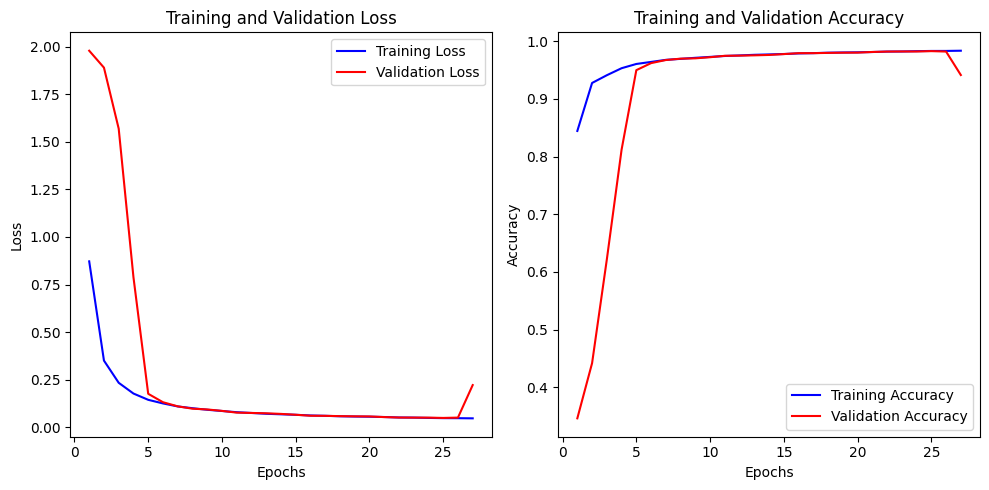

In [ ]:
def plot_loss_and_accuracy(model_history):
    # Get the training and validation loss and accuracy values from the model history
    train_loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    train_accuracy = model_history.history['accuracy']
    val_accuracy = model_history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_loss_and_accuracy(model_history1)

# Saving the model

In [ ]:
tf.keras.models.save_model(unet, 'unet.h5')